## Variance Reduction in Hull-White Monte Carlo Simulation Using Moment Matching
[Goutham Balaraman](http://gouthamanbalaraman.com)

In an [earlier blog post](http://gouthamanbalaraman.com/blog/hull-white-simulation-monte-carlo-convergence.html) on how the Hull-White Monte Carlo simulations are notorious for not coverging with some of the expected moments. In this post, I would like to touch upon a variance reduction technique called *moment matching* that can be employed to fix this issue of convergence. 

The idea behind moment matching is rather simple. Lets consider the specific example of short rate model. For the short rate model, it is known that the average of stochastic discount factors generated from each path has to agree with the model (or the give yield curve) discount factors. The idea of moment matching is to correct the short rates generated by the term structure model such that the average of stochastic discount factors from the simulation matches the model discount factors.


In [1]:
import QuantLib as ql
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import cumtrapz
ql.__version__

'1.11'

For simplicity, we use a constant forward rate as the given interest rate term structure. The method discussed here would work with any market yield curve as well.

In [2]:
sigma = 0.01
a = 0.001
timestep = 360
length = 30 # in years
forward_rate = 0.05
day_count = ql.Thirty360()
todays_date = ql.Date(15, 1, 2015)

In [3]:
ql.Settings.instance().evaluationDate = todays_date

yield_curve = ql.FlatForward(
    todays_date, 
    ql.QuoteHandle(ql.SimpleQuote(forward_rate)), 
    day_count)
spot_curve_handle = ql.YieldTermStructureHandle(yield_curve)

Here, I setup the Monte Carlo simulation of the Hull-White process. The result of the `generate_paths` function below is the time grid and a matrix of short rates generated by the model. This is discussed in detaio in the [Hull-White simulation post](http://gouthamanbalaraman.com/blog/hull-white-simulation-quantlib-python.html).

In [4]:
hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(
    ql.UniformRandomSequenceGenerator(
        timestep, 
        ql.UniformRandomGenerator(125)))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)

In [5]:
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

Here is a plot of the generated short rates.

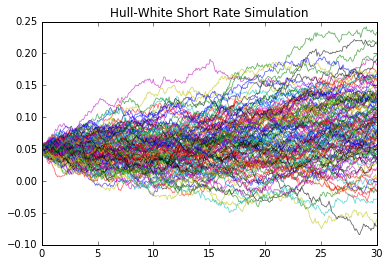

In [6]:

num_paths = 128
time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.8, alpha=0.6)
plt.title("Hull-White Short Rate Simulation")
plt.show()

The model zero coupon bond price $B(0, T)$ is given as:
$$B(0, T) = E\left[\exp\left(-\int_0^T r(t)dt \right) \right]$$
where $r(t)$ is the short rate generated by the model. The expectation of the stochastic discount factor at time $T$ is the price of the zero coupon bond at that time. In a simulation the paths are generated in a time grid and the discretization introduces some error. The empirical estimation of the zero coupon bond price from a Monte Carlo simulation $\hat{B}(0, t_m)$ maturing at time $t_m$ is  given as:

$$\hat{B}(0, t_m) = \frac{1}{N}\sum_{i=1}^{N} \exp\left(-\sum_{j=0}^{m-1} \hat{r}_i(t_j)[t_{j+1}-t_j] \right)$$

where $\hat{r}_i(t_j)$ is the short rate for the path $i$ at time $t_j$ on the time grid. The expression for the moment matched short rates is given as [1]:

$$ r^c_i(t_j) = \hat{r}_i(t_j) + \frac{\log \hat{B}(0, t_{j+1}) - \log \hat{B}(0, t_{j})}{t_{j+1} - t_j} 
- \frac{\log B(0, t_{j+1}) - \log B(0, t_{j})}{t_{j+1} - t_j}$$

In [7]:
def stoch_df(paths, time):
    return np.mean(
        np.exp(-cumtrapz(paths, time, initial=0.)),axis=0
    )
B_emp = stoch_df(paths, time)
logB_emp = np.log(B_emp)
B_yc = np.array([yield_curve.discount(t) for t in time])
logB_yc = np.log(B_yc)

In [8]:
deltaT = time[1:] - time[:-1]
deltaB_emp = logB_emp[1:]-logB_emp[:-1]
deltaB_yc = logB_yc[1:] - logB_yc[:-1]

In [9]:
new_paths = paths.copy()
new_paths[:,1:] += (deltaB_emp/deltaT - deltaB_yc/deltaT)

The plots below show the zero coupon bond price and mean of short rates with and without the moment matching.

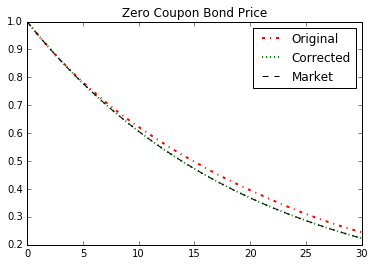

In [10]:
plt.plot(time,
         stoch_df(paths, time),"r-.", 
         label="Original", lw=2)
plt.plot(time,
         stoch_df(new_paths, time),"g:",
         label="Corrected", lw=2)
plt.plot(time,B_yc, "k--",label="Market", lw=1)
plt.title("Zero Coupon Bond Price")
plt.legend()

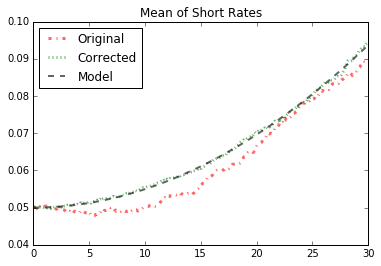

In [11]:
def alpha(forward, sigma, a, t):
    return forward + 0.5* np.power(sigma/a*(1.0 - np.exp(-a*t)), 2)

avg = [np.mean(paths[:, i]) for i in range(timestep+1)]
new_avg = [np.mean(new_paths[:, i]) for i in range(timestep+1)]
plt.plot(time, avg, "r-.", lw=3, alpha=0.6, label="Original")
plt.plot(time, new_avg, "g:", lw=3, alpha=0.6, label="Corrected")
plt.plot(time,alpha(forward_rate, sigma, a, time), "k--", lw=2, alpha=0.6, label="Model")
plt.title("Mean of Short Rates")
plt.legend(loc=0)

### Reference
[1] Paul Glasserman, *Monte Carlo Methods in Financial Engineering*, Chapter 4